# Interprétation des modèles d'apprentissage statistique
 
## A. Introduction 

L'interprétabilité des modèles joue un rôle central dans les projets de Machine Learning. On peut dire qu'un modèle est interprétable lorsqu'un humain peut comprendre et expliquer les raisons des décisions prises par ce dernier. Elle permet :

 * aux data scientists :
     * Déboguer le modèle
     * Inspecter le modèle : savoir pourquoi il marche bien ou pas 
     * Expliquer les résultats aux métiers
 
 * aux métiers :
     * Faire confiance aux modèles
     * Vérifier la conformité avec la réglementation
     * Comprendre et expliquer les décisions prises
 

## B. Partial Dependence Plots (PDP)  & Individual Conditional Expectation (ICE)

Le graphique de dépendance partielle montre l’effet marginal d'une variable sur la prédiction d'un modèle.
Il s'agit d'une moyenne des courbes individuelles pour un ensemble de valeurs d'une variable. 
Le PDP est une méthode globale dans la mesure où elle prend en compte un ensemble de valeurs d’une variable et fournit une indication sur la relation globale entre la variable et les valeurs prédites.

L'ICE est similaire au PDP mais au lieu de s'intéresser l'ensemble des données, on se focalise sur un seul individu. En sens il fait partie des méthodes dites locales.

## C. LIME (Local Interpretable Model-Agnostic Explanations)

LIME permet de mesurer l'impact des variables indépendamment de la complexité du modèle. Pour se faire LIME réalise les étapes suivantes :

* Générer des données synthétiques à partir d'un individu.
* Effectuer de prédictions avec ces nouvelles données en utilisant le modèle à rendre interprétable
* Entrainer un nouveau modèle interprétable (exemple : régression linéaire, arbre de décision) sur ces données avec une pondération en fonction de leur proximité avec l'individu

Ce modèle affecte un poids à chaque variable qui représente son importance dans l'explication fournie par LIME. 


## D. SHAP (SHapley Additive exPlanations)

Basée sur la théorie des jeux coopératifs, les valeurs de SHAP ont pour objectif d'expliquer la prédiction d'un individu en calculant la contribution de chaque variable à la valeur prédite. SHAP propose également une décomposition additive des contributions des variables.

SHAP fournit des graphiques permettant de visualiser l'impact de chaque variable sur la prédiction. La valeur de base correspond à la moyenne des prédictions de tous les individues à laquelle on ajoute les contributions (positives ou négatives) des variables.


## E. Application 

**Les données**

Les informations sur les données sont tirées des travaux du Professeur [Philippe Besse.](https://github.com/wikistat)

Les données ont été extraites et mises en forme par le service concerné de Météo France. Elles sont décrites par les variables suivantes :

* **JOUR** Le type de jour ; férié (1) ou pas (0) ;
* **O3obs** La concentration d'ozone effectivement observée le lendemain à 17h locales correspondant souvent au maximum de pollution observée ;
* **MOCAGE** Prévision de cette pollution obtenue par un modèle déterministe de mécanique des fluides (équation de Navier et Stockes);
* **TEMPE** Température prévue par MétéoFrance pour le lendemain 17h ;
* **RMH2O** Rapport d'humidité ;
* **NO2** Concentration en dioxyde d'azote ;
* **NO** Concentration en monoxyde d'azote ;
* **STATION** Lieu de l'observation : Aix-en-Provence, Rambouillet, Munchhausen, Cadarache et Plan de Cuques ;
* **VentMOD** Force du vent ;
* **VentANG** Orientation du vent

**Note** : L'objectif est de montrer comment on peut appliquer les techniques permettant d'interpréter les prévisions d'un modèle :
* On se limitera à la méthode des Random Forest
* On ne comparera pas la prévision obtenue avec les résultats du modèle déterministe de mécanique des fluides


### 1. Préprocessing et fitting du modèle

In [1]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from math import sqrt, log
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

sns.set()

In [2]:
data = pd.read_csv('data/depSeuil.txt', sep=",")
data.columns = data.columns.str.upper()
data["STATION"] = pd.Categorical(data["STATION"], ordered=False)
data["JOUR"] = pd.Categorical(data["JOUR"], ordered=False)
data["O3OBS"] = pd.DataFrame(data["O3OBS"], dtype=np.float64)
data.dtypes

JOUR       category
O3OBS       float64
MOCAGE      float64
TEMPE       float64
RMH2O       float64
NO2         float64
NO          float64
STATION    category
VENTMOD     float64
VENTANG     float64
dtype: object

In [3]:
categorical_features = ["JOUR", "STATION"]

categorical_names = {}
categorical_features_dummy = []
for idx, feature in enumerate(categorical_features):
    label_encoder = LabelEncoder()
    label_encoder.fit(data[feature])
    data[feature] = label_encoder.transform(data[feature])
    categorical_names[idx] = label_encoder.classes_
    categorical_features_dummy.extend(
      ['{}_{}'.format(feature, str(cat).upper()) for cat in label_encoder.classes_]
    )

data = data.astype(float)

In [4]:
data.head()

,JOUR,O3OBS,MOCAGE,TEMPE,RMH2O,NO2,NO,STATION,VENTMOD,VENTANG
0,1.0,91.0,93.2,21.5,0.00847,1.602,0.424,0.0,9.5000,-0.64350
1,1.0,100.0,104.6,20.2,0.00881,2.121,0.531,0.0,8.0100,-0.04996
2,0.0,82.0,103.6,17.4,0.00951,1.657,0.467,0.0,9.3771,-0.12832
3,0.0,94.0,94.8,18.8,0.00855,2.350,0.701,0.0,9.4578,-0.34516
4,0.0,107.0,99.0,23.7,0.00731,1.653,0.452,0.0,7.8791,-0.41822


In [5]:
data["SRMH2O"] = data["RMH2O"].map(lambda x: sqrt(x))
data["LNO2"] = data["NO2"].map(lambda x: log(x))
data["LNO"] = data["NO"].map(lambda x: log(x))

data = data.drop(["RMH2O", "NO2", "NO"], axis=1)
numerical_features = ["MOCAGE", "TEMPE", "VENTMOD", "VENTANG", "SRMH2O", "LNO2", "LNO"]

data.head()

,JOUR,O3OBS,MOCAGE,TEMPE,STATION,VENTMOD,VENTANG,SRMH2O,LNO2,LNO
0,1.0,91.0,93.2,21.5,0.0,9.5000,-0.64350,0.092033,0.471253,-0.858022
1,1.0,100.0,104.6,20.2,0.0,8.0100,-0.04996,0.093862,0.751888,-0.632993
2,0.0,82.0,103.6,17.4,0.0,9.3771,-0.12832,0.097519,0.505009,-0.761426
3,0.0,94.0,94.8,18.8,0.0,9.4578,-0.34516,0.092466,0.854415,-0.355247
4,0.0,107.0,99.0,23.7,0.0,7.8791,-0.41822,0.085499,0.502592,-0.794073


In [6]:
categorical_encoder = OneHotEncoder() #drop='first'
numerical_pipe = Pipeline([('imputer', SimpleImputer(strategy='mean'))])

preprocessing = ColumnTransformer(
    [('category', categorical_encoder, categorical_features),
     ('numeric', numerical_pipe, numerical_features)])

pipe = Pipeline([('preprocess', preprocessing),
                 ('regressor', RandomForestRegressor(random_state=125))])

In [7]:
target_name = 'O3OBS'
train, test = train_test_split(data, test_size=0.2, random_state=125)
X_train = train[categorical_features + numerical_features]
Y_train = train[target_name]
X_test = test[categorical_features + numerical_features]
Y_test = test[target_name]

In [8]:
%%time
param_grid = {"regressor__max_features": [0.6, 0.8],
              "regressor__n_estimators": [50, 100, 200, 300],
              "regressor__min_samples_split": [2, 3, 4],
              "regressor__min_samples_leaf": [2, 3, 4]
             }

model = GridSearchCV(pipe, param_grid, cv=3, n_jobs=3)
_ = model.fit(X_train, Y_train)

predictions = model.predict(X_test)
mse = mean_squared_error(Y_test, predictions)
print("MSE = {0:.2f}".format(mse))

MSE = 607.99
Wall time: 36.5 s


### 2. Graphiques ICE et PDP

In [9]:
from pycebox.ice import ice, ice_plot
from pdpbox import pdp, info_plots

In [10]:
best_model = model.best_estimator_[-1]
pipe_processing = model.best_estimator_[0]

In [11]:
feature_names = categorical_features_dummy + numerical_features
X_test_proc = pd.DataFrame(pipe_processing.transform(X_test), 
                           columns=feature_names)

**ICE les individus de l'échantillon de test pour la variable MOCAGE**

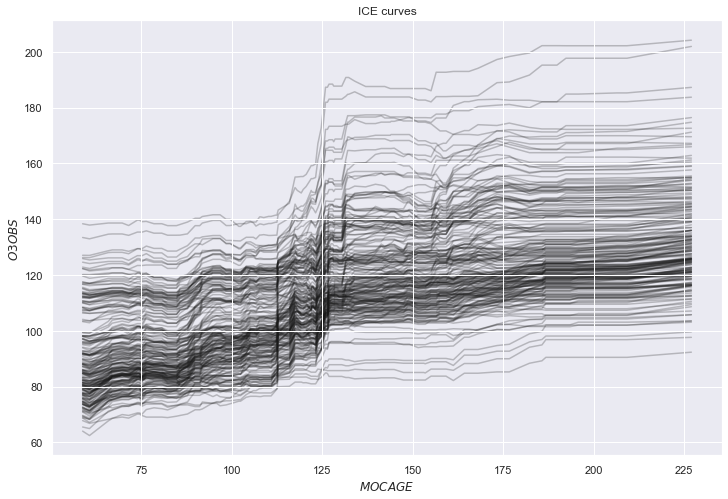

In [12]:
feature = 'MOCAGE'

ice_df = ice(X_test_proc, feature, best_model.predict, num_grid_points=100)
ice_plot(ice_df, frac_to_plot=4, c='k', alpha=0.25)
plt.xlabel('${}$'.format(feature))
plt.ylabel('${}$'.format(target_name));

plt.title('ICE curves');

**PDP pour la variable continu MOCAGE**

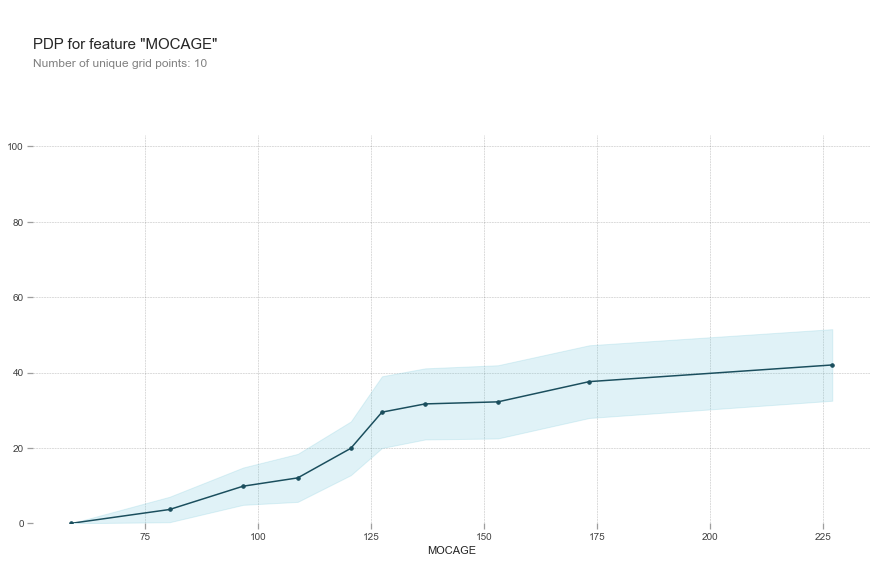

In [13]:
pdp_ = pdp.pdp_isolate(model=best_model, 
                       dataset=X_test_proc, 
                       model_features=feature_names,
                       feature=feature)
fig, axes = pdp.pdp_plot(pdp_, feature, plot_lines=False, frac_to_plot=100)

**PDP pour la variable categorielle STATION**

In [14]:
feature = ["STATION_AIX", "STATION_ALS", "STATION_CAD", "STATION_PLA", "STATION_RAM"]
feature_name = 'STATION'

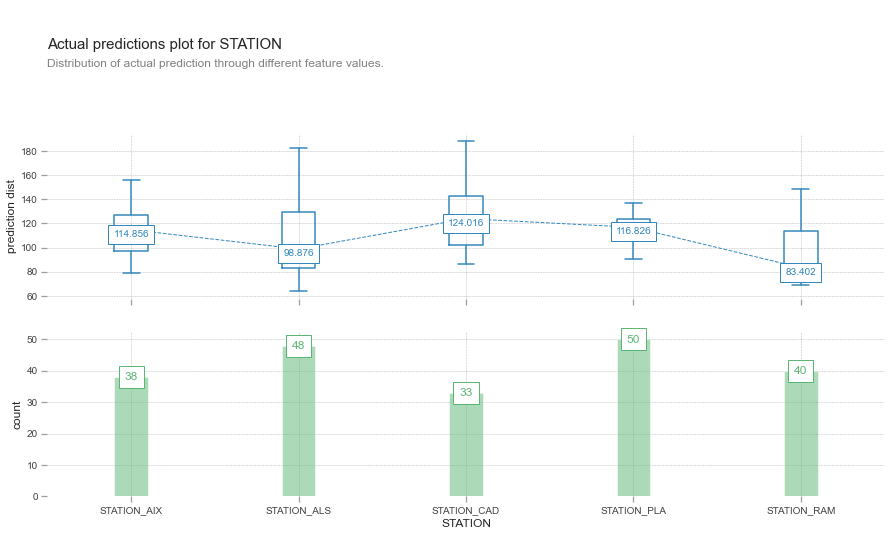

In [15]:
fig, axes, summary_df = info_plots.actual_plot(model=best_model, 
                                               X=X_test_proc, 
                                               feature=feature,
                                               feature_name=feature_name,
                                               predict_kwds={})

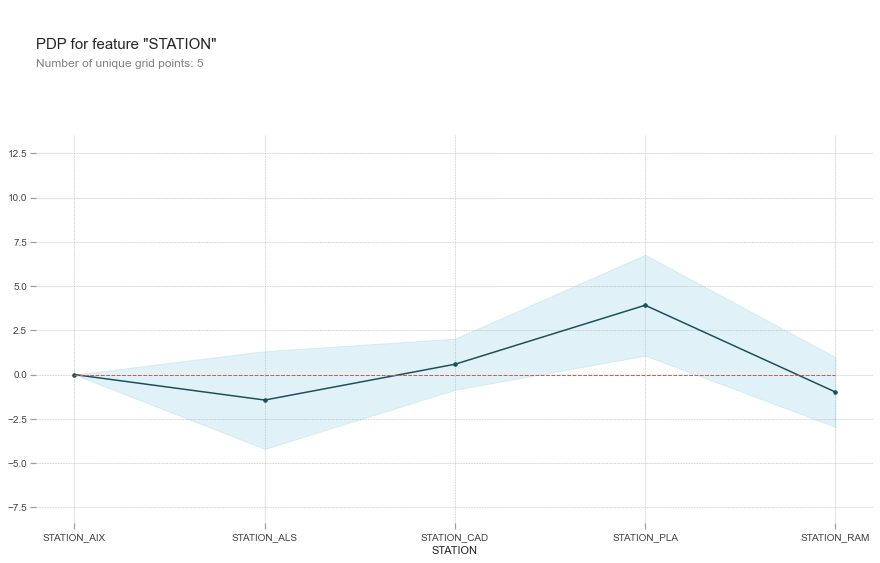

In [16]:
pdp_ = pdp.pdp_isolate(
    model=best_model, dataset=X_test_proc, model_features=feature_names, 
    feature=feature
)
fig, axes = pdp.pdp_plot(pdp_, feature_name, plot_lines=False, frac_to_plot=100)

### 3. Interprétation du modèle avec LIME

In [17]:
from lime.lime_tabular import LimeTabularExplainer

In [18]:
feature_names = X_train.columns.to_list()

def predict(x):
    df = pd.DataFrame(x)
    df.columns = feature_names
    return model.predict(df)

explainer = LimeTabularExplainer(training_data=X_train.to_numpy(),
                                 mode='regression',
                                 feature_names=feature_names,
                                 categorical_features=list(categorical_names.keys()),
                                 categorical_names=categorical_names,
                                 random_state=12345
                                )

In [19]:
idx = 39
exp = explainer.explain_instance(X_test.iloc[idx], predict, num_features=7)
exp.show_in_notebook(show_all=False)

Le graphique montre comment les variables influent sur la prédiction :
* En orange, les variables ayant un impact positif (augmentent la valeur de base)
* En bleu, les variables ayant un impact négatif (diminuent la valeur de base)

### 4. Interprétation du modèle avec SHAP

In [20]:
import shap
shap.initjs()

In [21]:
best_model = model.best_estimator_[-1]
pipe_processing = model.best_estimator_[0]

feature_names = categorical_features_dummy + numerical_features
X_test_proc = pd.DataFrame(pipe_processing.transform(X_test), 
                           columns=feature_names)
X_train_proc = pd.DataFrame(pipe_processing.transform(X_train), 
                           columns=feature_names)
X_train_summary = shap.kmeans(X_train_proc, 10)

**Expliquer les prédictions sur l'ensemble données de tests**

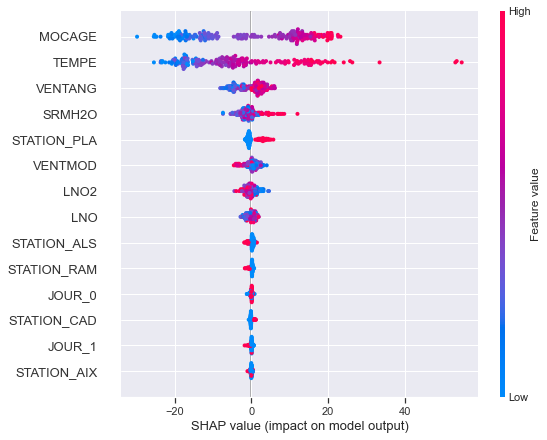

In [22]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_proc)
shap.summary_plot(shap_values, X_test_proc)

Le graphique représente les valeurs de Shap pour chaque variable dans leur ordre d'importance :
* Chaque point représente une valeur de Shap pour un individu
* Les points rouges correspondent aux valeurs élevées 
* Les points bleus représentent leurs valeurs basses

**Expliquer la prédiction pour un seul indivudu sur les données de tests**

In [23]:
idx = 39
shap_values = explainer.shap_values(X_test_proc.iloc[idx])
shap.force_plot(explainer.expected_value, shap_values, X_test_proc.iloc[idx])

Comme pour Lime, Shap fournit un graphique pour expliquer l'influence des variables la prédiction :
* La valeur de base (115.7 pour l'exemple)
* En rouge, les variables ayant un impact positif (augmentent la valeur de base)
* En bleu, les variables ayant un impact négatif (diminuent la valeur de base)

In [24]:
shap_values = explainer.shap_values(X_test_proc)

Analyse interactive des prédictions en fonction des variables et d'autres paramètres

In [25]:
shap.force_plot(explainer.expected_value, shap_values, X_test_proc)

Le graphique dépendence montre l'impact d'une variable sur les predictions. 

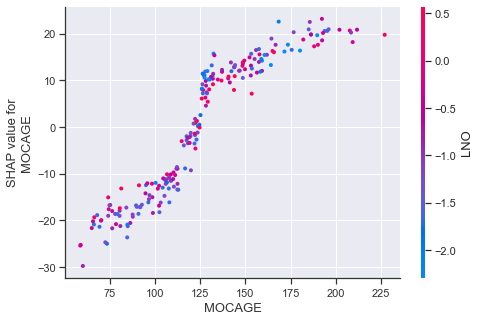

In [26]:
shap.dependence_plot("MOCAGE", shap_values, X_test_proc)

Shap permet aussi d'afficher les PDP.

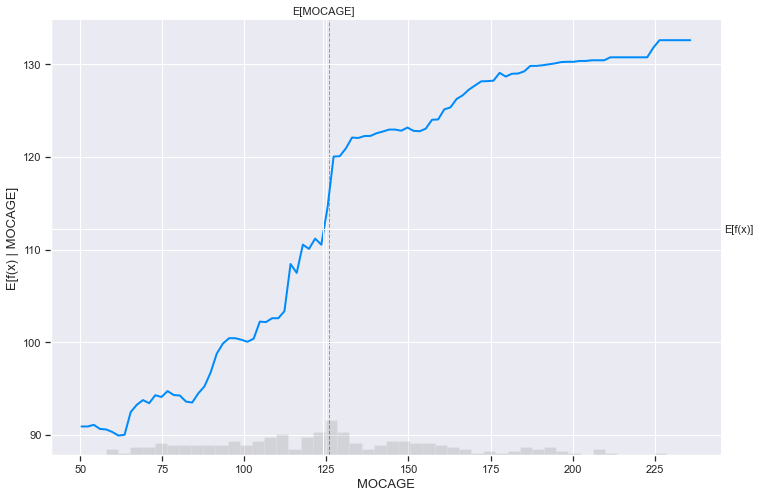

In [27]:
shap.plots.partial_dependence(
    "MOCAGE", best_model.predict, X_test_proc, ice=False,
    model_expected_value=True, feature_expected_value=True
)

Shap permet aussi d'afficher les PDP et ICE.

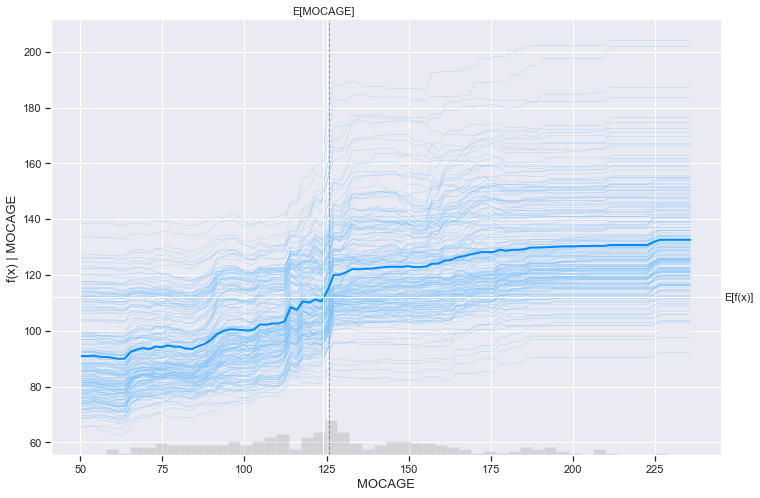

In [28]:
shap.plots.partial_dependence(
    "MOCAGE", best_model.predict, X_test_proc, ice=True,
    model_expected_value=True, feature_expected_value=True
)

**Références**:
 
[Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/)   
[SHAP documentation](https://shap.readthedocs.io/en/latest/index.html)       
[LIME documentation](https://lime-ml.readthedocs.io/en/latest/index.html)   
[PDPbox documentation](https://pdpbox.readthedocs.io/en/latest/index.html)   